# Original idea from here: https://habr.com/ru/articles/671778/

Compute covariance matrix for pixels channels in intermediate layers of model. Find Eigenvalues of matrices: https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix
If layer has too much filters at output, eigenvalues will have hude difference.
if layers filters all have valueable information, eigenvalues will be quite big.

After checking eigenvalues it's possible to find and eliminate bottlenecks in neural model.


In [1]:
import time
from typing import Optional, Tuple, List,  Dict, Callable

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import colorsys

from myutil import CovarianceAccumulator

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.__version__

'1.13.1+cu117'

In [4]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root='../models/mnist',
    train=True,
    transform=ToTensor(),
    download=True,
)

test_data = datasets.MNIST(
    root='../models/mnist',
    train=False,
    transform=ToTensor(),
    download=True,
)

In [5]:
class ExpandChannels(nn.Module):
    def __init__(self, in_ch: int, out_ch: int):
        super(ExpandChannels, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1, padding='valid', bias=False)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.cat([x, self.conv(x)], dim=1)

class CustomConv(nn.Module):
    @staticmethod
    def make(in_ch: int, mid_ch: int, out_ch: int, kernel_size: int) -> List[nn.Module]:
        result = []
        result.append(nn.Conv2d(in_ch, mid_ch, kernel_size=kernel_size, padding='valid', bias=False))
        if mid_ch != out_ch:
            result.append(ExpandChannels(mid_ch, out_ch - mid_ch))
        return result

In [6]:
class TrainHelper:
    @staticmethod
    def train(cnn: nn.Module,
              *,
              epochs: int,
              train_dataset: datasets.MNIST,
              test_dataset: Optional[datasets.MNIST] = None,
              print_results: bool = True,
              batch_size: int = 2048,
              device_name: str = 'cuda') -> List[float]:

        train_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=1)

        device = torch.device(device_name)

        cnn.to(device)
        cnn.train()

        optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
        loss_func = nn.CrossEntropyLoss()

        eval_results: List[float] = []

        for epoch in range(epochs):
            for images, labels in train_loader:
                images = Variable(images.to(device))
                labels = Variable(labels.to(device))

                output = cnn(images)
                loss = loss_func(output, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if test_dataset is not None:
                eval_result = TrainHelper.test(cnn, test_dataset, device)
                eval_results.append(eval_result)
                if print_results:
                    print(f"epoch {epoch}, accuracy = {eval_result}, loss = {loss.detach()}")
                cnn.train()

        return eval_results

    @staticmethod
    def test_covariance(cnn: 'MyConvModel',
                        test_dataset: datasets.MNIST,
                        device=None) -> Dict[str, CovarianceAccumulator]:
        flat_layers = cnn.flat_layers()
        stats: Dict[nn.Module, CovarianceAccumulator] = {}
        stats['input'] = CovarianceAccumulator()
        for layer in flat_layers:
            stats[layer] = CovarianceAccumulator()
            
        def convert(tensor: torch.Tensor) -> np.ndarray:
            arr = tensor.detach().cpu().numpy()
            if len(arr.shape) == 4:
            # shape = batch, channels, x, y
                arr = np.moveaxis(arr, 1, 3)
                arr = np.reshape(arr, (-1, arr.shape[3]))
            assert len(arr.shape) == 2
            return arr

        with torch.no_grad():
            loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=1)
            for images, _ in loader:
                if device is not None:
                    images = images.to(device)

                x = images
                stats['input'].add_samples(convert(x))
                for module in flat_layers:
                    x = module(x)
                    stats[module].add_samples(convert(x))

        return stats

    @staticmethod
    def test(cnn: nn.Module, test_dataset: datasets.MNIST, device=None) -> float:
        cnn.eval()
        loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=1)
        correct = 0
        incorrect = 0

        with torch.no_grad():
            for images, labels in loader:
                if device is not None:
                    images = images.to(device)

                results = cnn(images)
                predictions = results.detach().cpu().numpy().argmax(axis=1)
                oks = (predictions == labels.numpy()).sum()
                correct += oks
                incorrect += len(predictions) - oks

        return correct / (correct + incorrect)

    @staticmethod
    def train_models(models: List[nn.Module], device_name: str) -> Tuple[int, float]:
        """
        generator yields pair (trainable parameters count, best accuracy) for each network
        :param device_name: 'cuda' or 'cpu'
        """
        assert len(models) > 0

        for model in models:
            start = time.time()
            eval_results = TrainHelper.train(
                cnn=model,
                epochs=20,
                train_dataset=train_data,
                test_dataset=test_data,
                batch_size=2048,
                device_name=device_name,
                print_results=False
            )
            end = time.time()
            best_acc = max(eval_results)
            params_count = TrainHelper.total_parameters_count(model)
            print(f"best accuracy = {best_acc}, parameters = {params_count}, training time = {end - start}")
            yield params_count, best_acc

    @staticmethod
    def total_parameters_count(model: nn.Module) -> int:
        return sum(np.prod(p.size()) for p in model.parameters())

    @staticmethod
    def print_parameters(model: nn.Module):
        print(f"total parameters = {TrainHelper.total_parameters_count(model)}")
        for p in model.parameters():
            print(f"size {np.prod(p.size())}: {p.size()}")

    @staticmethod
    def show_stats(stats: Dict[nn.Module, CovarianceAccumulator], layers_filter: Callable[[nn.Conv2d], bool]):
        plt.rcParams['figure.figsize'] = [12, 12]
        fig, ax = plt.subplots()
        ax.set_yscale("log")
    
        for i, (module, stat) in enumerate([(m, s) for m, s in stats.items() if layers_filter(m)]):
            eigenvalues = stat.eigenvalues
            x = list(range(1, 1 + len(eigenvalues)))
            color = colorsys.hsv_to_rgb(i * 0.08, 1.0, 1.0)
            ax.plot(x, eigenvalues, c=color)
    
        plt.show()
        
    @staticmethod
    def show_stats_conv(stats: Dict[nn.Module, CovarianceAccumulator]):
        TrainHelper.show_stats(stats, lambda m: isinstance(m, (nn.Conv2d, CustomConv)))

    @staticmethod
    def show_stats_relu(stats: Dict[nn.Module, CovarianceAccumulator]):
        TrainHelper.show_stats(stats, lambda m: isinstance(m, (nn.LeakyReLU, nn.Flatten)))

In [7]:
class MyConvModel(nn.Module):
    def __init__(self, channels: int):
        super(MyConvModel, self).__init__()

        c = channels
        self.layers = nn.Sequential(
            self.conv(1, c, c, kernel_size=3),  # 28 - 26
            self.conv(c, c, c, kernel_size=3),  # 26 - 24
            nn.MaxPool2d(2),  # 24 - 12

            self.conv(c, c * 2, c * 2, kernel_size=3),  # 12 - 10
            self.conv(c * 2, c * 2, c * 2, kernel_size=3),  # 10 - 8
            nn.MaxPool2d(2),  # 8 - 4

            self.conv(c * 2, c * 4, c * 4, kernel_size=3),  # 4 - 2
            self.conv(c * 4, c * 4, c * 4, kernel_size=2),  # 2 - 1

            nn.Conv2d(c * 4, 10, kernel_size=1, padding='valid', bias=True),
            nn.Flatten(),
        )

    def flat_layers(self) -> List[nn.Module]:
        def walk(module: nn.Module) -> nn.Module:
            if isinstance(module, nn.Sequential):
                for child in module.children():
                    yield from walk(child)
            else:
                yield module

        return list(walk(self.layers))

    def conv(self, in_ch: int, mid_ch: int, out_ch: int, *, kernel_size):
        return nn.Sequential(
            *CustomConv.make(in_ch, mid_ch, out_ch, kernel_size=kernel_size),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.1),
        )

    def forward(self, x: torch.Tensor):
        return self.layers(x)

epoch 0, accuracy = 0.741, loss = 0.4812144339084625
epoch 1, accuracy = 0.9795, loss = 0.21057114005088806
epoch 2, accuracy = 0.9889, loss = 0.11534657329320908
epoch 3, accuracy = 0.9908, loss = 0.07727968692779541
epoch 4, accuracy = 0.9902, loss = 0.057598911225795746


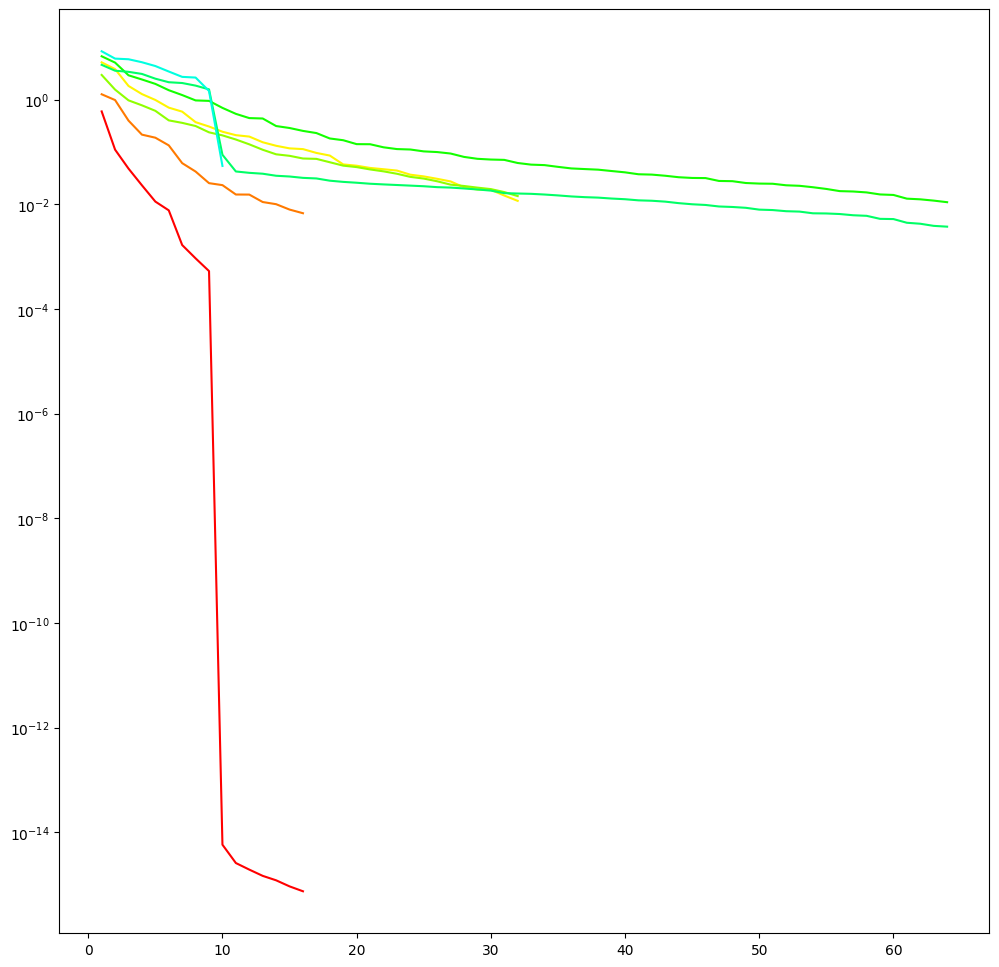

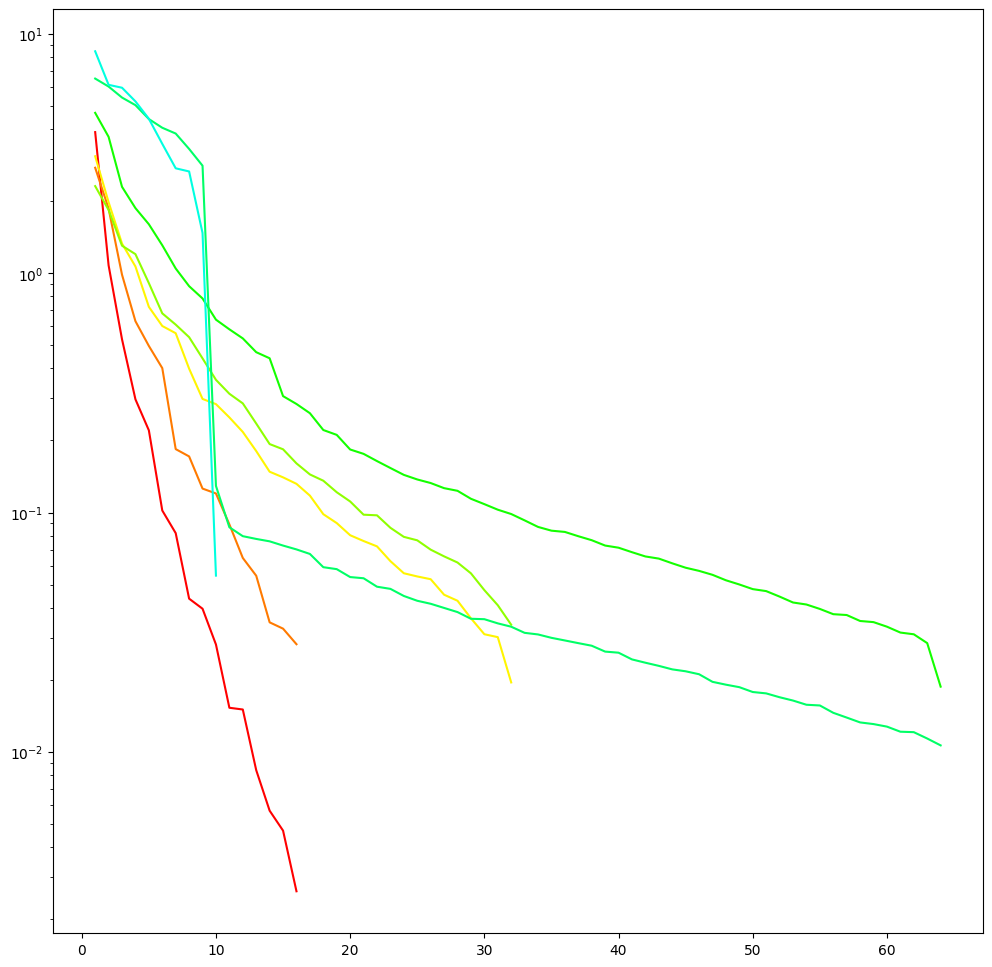

In [8]:
model = MyConvModel(16).to('cuda')
_ = TrainHelper.train(model, 
                      epochs=5, 
                      train_dataset=train_data, 
                      test_dataset=test_data)
stats = TrainHelper.test_covariance(model, test_data, device='cuda')
TrainHelper.show_stats_conv(stats)
TrainHelper.show_stats_relu(stats)

epoch 0, accuracy = 0.5316, loss = 1.3626232147216797
epoch 1, accuracy = 0.9399, loss = 1.048982858657837
epoch 2, accuracy = 0.973, loss = 0.7754884958267212
epoch 3, accuracy = 0.9819, loss = 0.5602425932884216
epoch 4, accuracy = 0.9867, loss = 0.42795759439468384
epoch 5, accuracy = 0.9892, loss = 0.32081320881843567
epoch 6, accuracy = 0.9896, loss = 0.2458552122116089
epoch 7, accuracy = 0.9906, loss = 0.18846023082733154
epoch 8, accuracy = 0.9916, loss = 0.15674926340579987
epoch 9, accuracy = 0.9911, loss = 0.12303993850946426


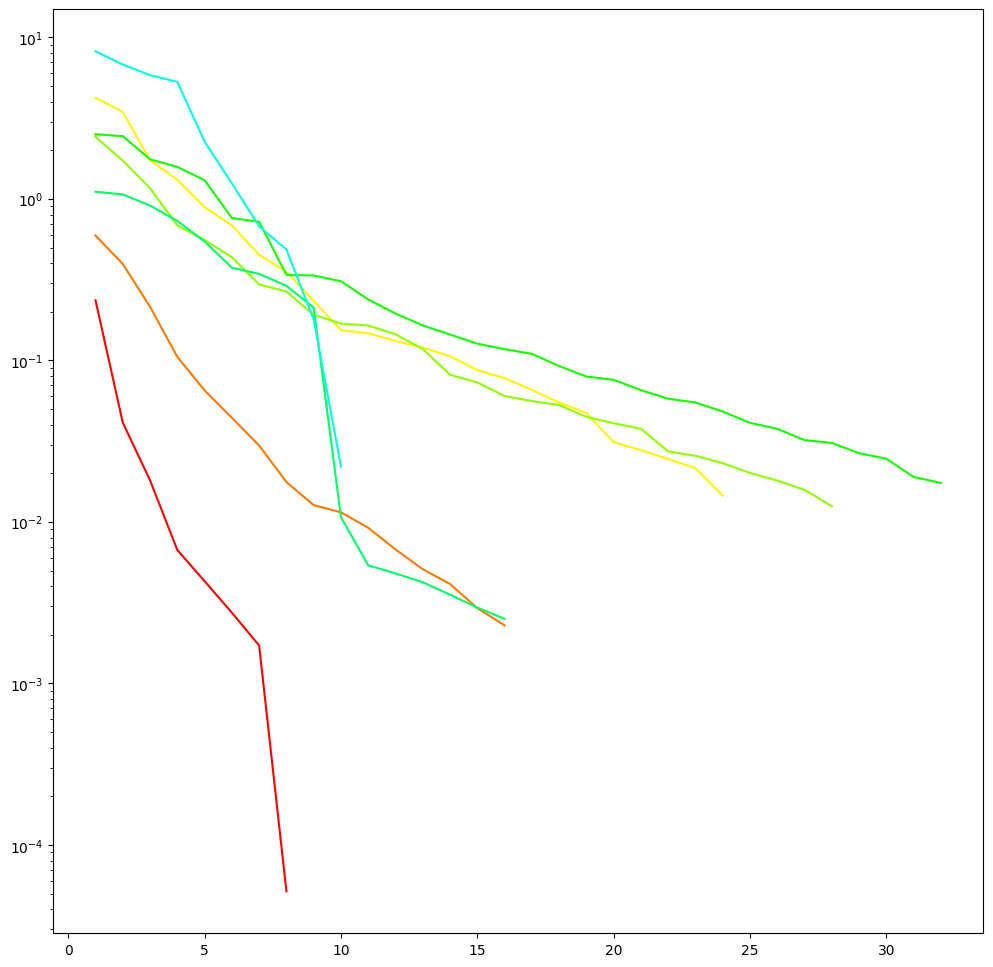

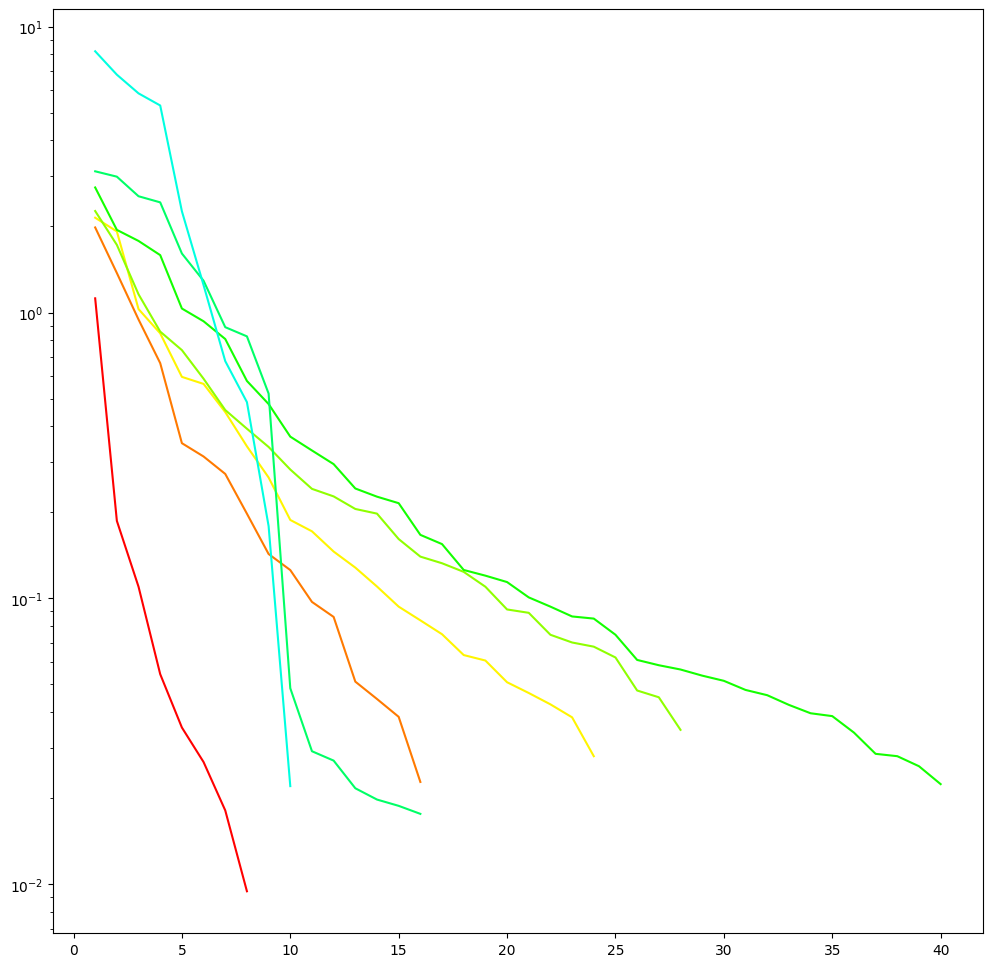

In [9]:
class MyCustomConvModel(nn.Module):
    def __init__(self):
        super(MyCustomConvModel, self).__init__()

        self.layers = nn.Sequential(
            self.conv(1, 8, 8, kernel_size=3),  # 28 - 26
            self.conv(8, 16, 16, kernel_size=3),  # 26 - 24
            nn.MaxPool2d(2),  # 24 - 12

            self.conv(16, 24, 24, kernel_size=3),  # 12 - 10
            self.conv(24, 28, 28, kernel_size=3),  # 10 - 8
            nn.MaxPool2d(2),  # 8 - 4

            self.conv(28, 32, 40, kernel_size=3),  # 4 - 2
            self.conv(40, 16, 16, kernel_size=2),  # 2 - 1

            nn.Conv2d(16, 10, kernel_size=1, padding='valid', bias=True),
            nn.Flatten(),
        )

    def flat_layers(self) -> List[nn.Module]:
        def walk(module: nn.Module) -> nn.Module:
            if isinstance(module, nn.Sequential):
                for child in module.children():
                    yield from walk(child)
            else:
                yield module

        return list(walk(self.layers))

    def conv(self, in_ch: int, mid_ch: int, out_ch: int, *, kernel_size):
        return nn.Sequential(
            *CustomConv.make(in_ch, mid_ch, out_ch, kernel_size=kernel_size),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.1),
        )

    def forward(self, x: torch.Tensor):
        return self.layers(x)

model_custom = MyCustomConvModel().to('cuda')
_ = TrainHelper.train(model_custom,
                      epochs=10,
                      train_dataset=train_data,
                      test_dataset=test_data)
stats_custom = TrainHelper.test_covariance(model_custom, test_data, device='cuda')
TrainHelper.show_stats_conv(stats_custom)
TrainHelper.show_stats_relu(stats_custom)